In [56]:
import pandas as pd
import numpy as np
import requests
import os
import hvplot.pandas
from dotenv import load_dotenv
from pathlib import Path
from time import sleep

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler, Normalizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

load_dotenv()

True

# Using polygon API get past year historical prices

* Loop through list of chosen stock symbols
* build dataframe for each ticker and append to master list

In [64]:
def get_symbols(symbols, begin_date=None, end_date=None):
    out = pd.DataFrame()
    BASE_URL = 'https://api.polygon.io'
    BARS_URL = '/v2/aggs/ticker/{}/range/{}/{}/{}/{}?apiKey={}&limit=50000'
    for symbol in symbols:
        data = requests.get(f"{BASE_URL}{BARS_URL.format(symbol, 1, 'day', begin_date, end_date, os.getenv('POLYGON_API_KEY'))}").json()
        df = pd.DataFrame(data['results'])
        df['t'] = pd.to_datetime(df['t'], unit='ms').dt.normalize()
        df = df.rename(columns={'v': 'volume', 'vw': 'weighted_volume', 'o': 'open', 'c': 'close', 'h': 'high', 'l': 'low', 't': 'date', 'n':'transaction_count'})
        df['symbol'] = symbol
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0)
        sleep(1)
    return out.sort_index()
        
prices = get_symbols(['MRNA','AZN', 'PFE', 'JNJ'],  '2020-05-15', '2021-09-18')

# Features are generated and scaled

* Generate features utilizing certain TA metrics
* Metrics are derived from aggregated bars and utilized for equations that generate signals

In [65]:
features = pd.DataFrame(index=prices.index)

features['lagged_returns'] = prices.groupby(level='symbol').close.pct_change().shift()

features['5_day_returns'] = prices.groupby(level='symbol').close.pct_change(5)

features['volume_change'] = prices.groupby(level='symbol').volume.diff(1) / prices.groupby(level='symbol').shift(1).volume

features['100_day_ma'] = prices.volume/ prices.volume.groupby(level='symbol')\
.apply(lambda x: x.rolling(100).mean())-1

features['50_day_ema'] = prices.close/ prices.close.groupby(level='symbol')\
.apply(lambda x: x.ewm(span=50).mean())-1

features['z_score'] =prices.groupby(level='symbol').close.apply(lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std())

features['percentile_transformation'] = prices.groupby(level='symbol').volume.apply(lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0]))

prices['21-high'] = prices['high'].rolling(21).max()
prices['21-low'] = prices['low'].rolling(21).mean()
features['stochastic_k'] = (prices['close'] - prices['21-low']) * 100 / (prices['21-high'] - prices['21-low'])
features['stochastic_d'] = features['stochastic_k'].rolling(3).mean()

target = prices.groupby(level='symbol').close.pct_change()

features.dropna(inplace=True)

In [66]:
features

lagged_returns  5_day_returns  volume_change  100_day_ma  \
date       symbol                                                             
2020-10-06 AZN           0.010170      -0.025404      -0.448881   -0.414330   
           JNJ          -0.014315      -0.005440       0.034328   -0.219603   
           MRNA         -0.013290       0.007374       0.117732   -0.645779   
           PFE          -0.012648       0.000000       0.304696   -0.148101   
2020-10-07 AZN          -0.015782      -0.023175      -0.047694   -0.442054   
...                           ...            ...            ...         ...   
2021-09-16 PFE           0.014248      -0.033891      -0.226805   -0.261271   
2021-09-17 AZN          -0.006701      -0.012442       0.366676   -0.192349   
           JNJ          -0.018375      -0.013296       1.369079    1.099338   
           MRNA         -0.002845      -0.043015       2.021194    1.028805   
           PFE          -0.024055      -0.037289       1.516066    0.836478   

                   50_day_ema   z_score  percentile_transformation  \
date       symbol                                                    
2020-10-06 AZN      -0.025414 -0.696012                   0.220000   
           JNJ      -0.010439 -0.198787                   0.960000   
           MRNA      0.042237  0.456516                   0.630000   
           PFE      -0.014937 -0.112316                   0.510000   
2020-10-07 AZN      -0.027567 -0.798444                   0.227723   
...                       ...       ...                        ...   
2021-09-16 PFE      -0.008201  1.289985                   0.955000   
2021-09-17 AZN      -0.034763  0.412929                   0.120000   
           JNJ      -0.035404  0.007022                   0.700000   
           MRNA      0.159211  2.132493                   0.990000   
           PFE      -0.020324  1.134413                   0.975000   

                   stochastic_k  stochastic_d  
date       symbol                              
2020-10-06 AZN       -29.077555    -28.286153  
           JNJ        95.046268      5.258718  
           MRNA       -6.835434     19.711093  
           PFE       -50.909611     12.433741  
2020-10-07 AZN       -29.254565    -28.999870  
...                         ...           ...  
2021-09-16 PFE       -41.125707     15.878206  
2021-09-17 AZN       -37.606717      4.204483  
           JNJ        -2.659764    -27.130729  
           MRNA       87.611084     15.781534  
           PFE       -42.511018     14.146767  

[960 rows x 9 columns]

# Scale values using standard scaler

* 

In [67]:
std_scaler = StandardScaler()
features_df = pd.DataFrame(std_scaler.fit_transform(features.dropna()), index=features.dropna().index)
features_df.columns = features.dropna().columns

target_temp = target.to_frame()
target_df = pd.DataFrame(std_scaler.fit_transform(target_temp.dropna()), index=target_temp.dropna().index)
target_df.columns = target_temp.columns

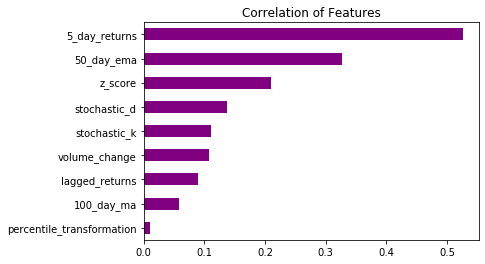

In [68]:
corr = features_df.corrwith(target)
corr.sort_values().plot.barh(color = 'purple',title = 'Correlation of Features')

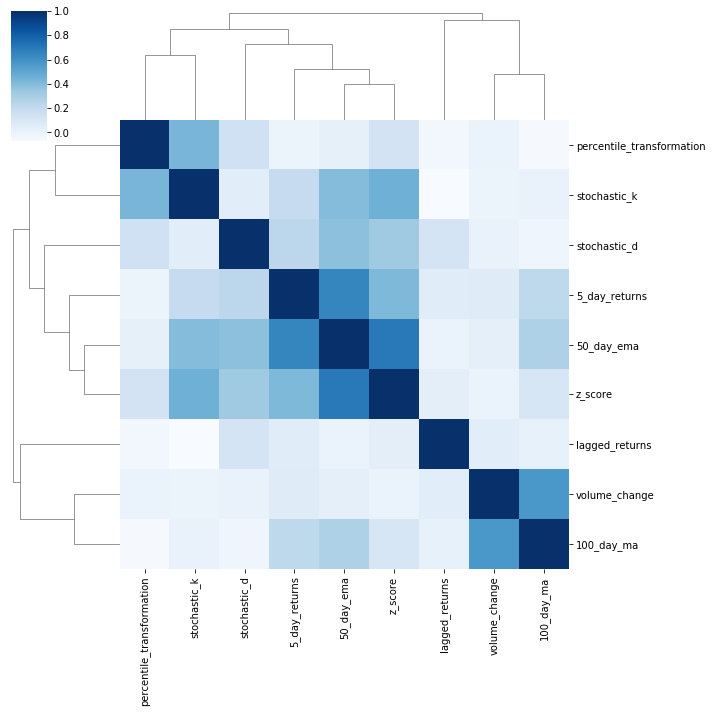

In [69]:
corr_matrix = features.corr()
corr_array = np.array(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(corr_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Blues')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [70]:
features_df.to_csv(Path('../Data/financial_features.csv'))
target_df.to_csv(Path('../Data/target.csv'))